In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
import kaggle
kaggle.api.dataset_download_files(dataset="youssefaboelwafa/hotel-booking-cancellation-prediction", path="./Data/", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/youssefaboelwafa/hotel-booking-cancellation-prediction


In [3]:
hotel = pd.read_csv("./Data/booking.csv", decimal='.')

In [ ]:
X = hotel.copy()
X['booking status'] = X['booking status'].map({'Not_Canceled': 0, 'Canceled': 1})
y = X.pop('booking status') 

X['date of reservation'] = X['date of reservation'].replace("2018-2-29", "2/28/2018")
X['arrival_date_month'] = pd.to_datetime(X['date of reservation']).dt.month

features_num = [
    "lead time", "arrival_date_month", "number of weekend nights",
    "number of week nights", "number of adults", "number of children", 
    "repeated", "P-C", "P-not-C", "car parking space", 
    "special requests", "average price",
]
features_cat = [
    "type of meal", "market segment type", "room type",
]

In [ ]:
transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"),  
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]


In [9]:
model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [10]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - binary_accuracy: 0.7190 - loss: 0.5928 - val_binary_accuracy: 0.7697 - val_loss: 0.5063
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.8013 - loss: 0.4463 - val_binary_accuracy: 0.7881 - val_loss: 0.4650
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.8096 - loss: 0.4167 - val_binary_accuracy: 0.8154 - val_loss: 0.4248
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.8162 - loss: 0.4050 - val_binary_accuracy: 0.8275 - val_loss: 0.4015
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.8201 - loss: 0.4013 - val_binary_accuracy: 0.8365 - val_loss: 0.3833
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.8254 - loss: 0.3872 - val_binary_accuracy: 0.8438 - val_loss: 0.3711
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.8232 - loss: 0.3853 - val_binary_accuracy: 0.8467 - val_loss: 0.3653
Epoch 8/200


<Axes: title={'center': 'Accuracy'}>

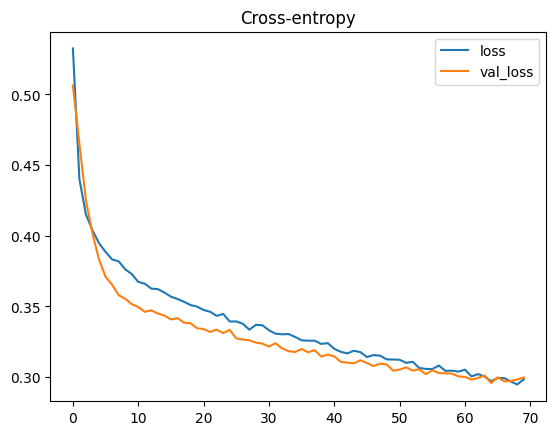

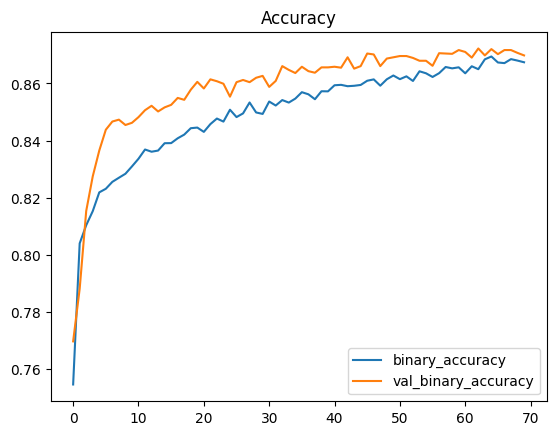

In [11]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")